This notebook the first level MRI analyses: setting up and examining a General Linear Model that produces response amplitudes for each stimulus class. For this, the data must be preprocessed. We will use GLMdenoise to do this, which is a MATLAB toolbox, and so the actual analysis will be run outside of this notebook (it takes a while and a lot of resources anyway, so this is for the best).

# Creating the design matrix

The first thing we need to do is create our design matrix. Our design matrix needs to be in the format time by conditions (where time is in TRs), with a 1 for condition onset. This will be exceedingly sparse, since each condition only shows up once per run (when we move this into matlab, we will make it a sparse matrix). We will have one of these design matrices per run.

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This file contains the button presses (which also show the TR onsets) 
# and the order the stimuli were presented in (along with their timing)
results = h5py.File('../data/raw_behavioral/2017-Aug-23_Noah_sess1.hdf5')

# This contains the information on each stimulus, allowing us to determine whether
# some stimuli are part of the same class or a separate one.
df = pd.read_csv("../data/stimuli/unshuffled_stim_description.csv", index_col=0)

Backticks from the scanner are recorded as 5s, which we hold onto, allowing us to quickly see how many TRs we recorded in each run (the last run is empty because we quit it as soon as it started):

In [3]:
for run in range(9):
    n_TRs = sum(['5' in i[0] for i in results['run_%02d_button_presses' % run].value])
    print("Run %s: %s TRs" % (run, n_TRs))


Run 0: 256 TRs
Run 1: 256 TRs
Run 2: 256 TRs
Run 3: 256 TRs
Run 4: 256 TRs
Run 5: 256 TRs
Run 6: 256 TRs
Run 7: 256 TRs
Run 8: 0 TRs


We also have the onset times of all of our stimuli, as well as an identifying index we can use to look up its information. We know that we presented stimuli in classes, each of which contains 8 stimuli, but we can reconstruct that information by using the indices to look into the dataframe we loaded in.

Based on how we constructed our stimuli, two stimuli belong to the same class iff they have the same `w_a` and `w_r` (angular and radial frequency) values.

In [3]:
reduced_df = df[['w_r', 'w_a', 'index']].set_index('index')
reduced_df = reduced_df.reindex(results['run_01_shuffled_indices'].value)

As can be seen by examining this reordered dataframe, our classes occur in batches of 8 (note that there are some that have `NaN`s for both values; these are the blank stimuli).

In [7]:
reduced_df

,w_r,w_a
index,,
402,16.0,-28.0
404,16.0,-28.0
400,16.0,-28.0
403,16.0,-28.0
406,16.0,-28.0
401,16.0,-28.0
405,16.0,-28.0
407,16.0,-28.0
121,23.0,0.0


One way to discover this programmatically is to find the smallest amount we have to jump by such that each subsequent entry has a different `w_r` and a different `w_a`.

In [4]:
class_size = 0
break_out = False
while ~break_out:
    class_size += 1
    w_r = reduced_df['w_r'].values.copy()
    w_a = reduced_df['w_a'].values.copy()
    # we replace the NaNs with zeros for this calculation -- we want them be different than all
    # the other classes (and technically, the blank stimuli do have 0s in both w_r and w_a)
    nan_replace = 0
    w_r[np.isnan(w_r)] = nan_replace
    w_a[np.isnan(w_a)] = nan_replace
    tmp = np.abs(w_r[:-class_size:class_size] - w_r[class_size::class_size]) + np.abs(w_a[:-class_size:class_size] - w_a[class_size::class_size])
    class_changes = np.nonzero(tmp)[0]
    indices = np.array(range(len(tmp)))
    if len(class_changes) == len(indices):
        break_out = np.equal(class_changes, indices).all()
print("Each class is of size %s" % class_size)

Each class is of size 8


We want to know what the class index of each stimulus is then, which we can find by dividing the index by the number of stimuli in each class:

In [5]:
reduced_df['class_idx'] = reduced_df.index/class_size

Now we want to figure out what TR each stimulus was presented during. We have the time (in seconds) they appeared on screen recorded, so we want to add that information to our dataframe. In order to do so, we will first subtract off the time of the first TR (so we now have the "time of presentation from first TR") and throw out a bit of extra information. We also recorded when the start screen was turned off (that's the first entry) and there are a final number of blank stimuli, which we'll throw away as well

In [6]:
timing = results['run_01_timing_data'].value
# Because we want to skip the first one and drop the last nblanks * 2 (since for each stimuli
# we have two entries: one for on, one for off). Finally, we only grab every other because we
# only want the on timing
timing = timing[1:-results['run_01_nblanks'].value*2:2]

# Now we get rid of the first TR
initial_TR_time = float(results['run_01_button_presses'].value[0][1])
timing = [float(i[2]) - initial_TR_time for i in timing]

# and add to our dataframe
reduced_df['Onset time (sec)'] = timing

Now we simply look for where there's a class transition, which happens every `class_size` (8) stimuli

In [7]:
design_df = reduced_df[::class_size]

Now we need to convert these to to TR times. First we find the onset times of TRs, in seconds, relative to the first TR. We then create a giant matrix where each row is a different stimulus onset time and then, in each column, subtract a TR onset time (so this matrix will be `num_conditions x num_TRs`). If we then round this difference-in-time matrix and look for the 0s, we've found what TR onset is closest to the onset of the stimuli. Note that this won't make sense for a lot of entries; some of them start almost exactly halfway through a TR. But, because of how we defined our experiment, our class transitions should happen right around a TR onset (if the timings of the scanner and the stimulus computer were perfect, then they would be exactly the same; as it is they probably differ by a few milliseconds) and so this will work

In [8]:
# 5 indicates a backtick from the scanner
TR_times = np.array([float(i[1]) for i in results['run_01_button_presses'].value if '5'==i[0]])
TR_times -= TR_times[0]

In [9]:
stim_times = design_df['Onset time (sec)'].values
stim_times = np.expand_dims(stim_times,1)
stim_times = np.repeat(stim_times,len(TR_times),1)

In [10]:
time_from_TR = np.round(stim_times - TR_times)
design_df['Onset time (TR)'] = np.where(time_from_TR==0)[1]

/home/billbrod/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


And we create our design matrix, iterate through throw our `design_df` and put a one where each class shows up in a TR.

In [11]:
# Our blanks show up as having nan values, and we don't want to model them in our GLM, so we drop them.
design_df = design_df.dropna()
# because the values are 0-indexed
design_matrix = np.zeros((len(TR_times), design_df.class_idx.max()+1))

for i, row in design_df.iterrows():
    row = row.astype(int)
    design_matrix[row['Onset time (TR)'], row['class_idx']] = 1

To make sure things work correctly, we look at our axis sums: each class (axis 1) should show up exactly once and each TR (axis 0) should have 0 or 1 classes in it

In [13]:
print("Each entry represents one of our %d classes:" % design_matrix.shape[1])
print(design_matrix.sum(0))

print("Each entry represents one of our %d TRs:" % design_matrix.shape[0])
print(design_matrix.sum(1))


Each entry represents one of our 52 classes:
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Each entry represents one of our 256 TRs:
[ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.

And now we can look at our design matrix for this run!

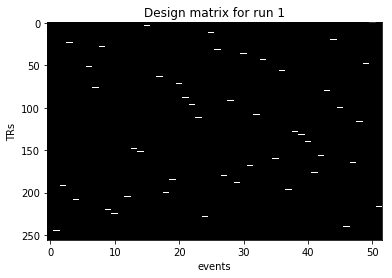

In [26]:
ax = plt.imshow(design_matrix, 'gray', aspect='auto',)
plt.title("Design matrix for run 1")
plt.xlabel("events")
plt.ylabel("TRs")

The function `sfp.first_level_analysis.design_matrix` does the above (without the visualizations and checks) and returns the resulting design matrix. The function `sfp.first_level_analysis.create_all_design_matrices` does this for multiple runs and saves them as `.mat` files so they can be read into matlab.

Actually running the first-level analysis requires matlab and should be run on the cluster (see `matlab/runGLM.m` and `matlab/runGLM.sbatch`), since they require Kendrick Kay's [GLMdenoise](http://kendrickkay.net/GLMdenoise/) package and use a lot of memory. After you've finished getting the results, examined the $R^2$ values to make sure they make sense, and realigned them to the subject's freesurfer anatomy (using `sfp.realign`), then you're ready for the following section, where we analyze these results.

# Analyzing the first-level results

After running our GLM analysis, we have the estimated amplitude responses of each voxel to each image class. Along with Noah Benson's anatomical template / Bayesian model, we also have each voxel's visual area and location in the visual field (in terms of eccentricity and polar angle). By combining the information contained within them, along with the dataframe describing each stimulus class, we can construct our tuning curves.

In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import h5py
import os
import itertools
import pyPyrTools.JBhelpers as jbh
import pyPyrTools as ppt

In [2]:
# This file contains the button presses (which also show the TR onsets) 
# and the order the stimuli were presented in (along with their timing)
behav_results = h5py.File('../data/raw_behavioral/2017-Oct-09_wl_subj001_sess1.hdf5')

# This contains the information on each stimulus, allowing us to determine whether
# some stimuli are part of the same class or a separate one.
stim_df = pd.read_csv("../data/stimuli/unshuffled_stim_description.csv", index_col=0)

# Array full of the actual stimuli
stim = np.load('../data/stimuli/unshuffled.npy')

# for this, we just want any run, since they all contain the same classes and we don't care about their order
design_df, _, _ = sfp.first_level_analysis.create_design_df(behav_results, stim_df, 1)
design_df = design_df.reset_index(drop=True).sort_values(by="class_idx")
design_df = design_df[['w_r', 'w_a', 'class_idx']].set_index('class_idx')

stim_df = stim_df.set_index(['w_r', 'w_a'])
stim_df['class_idx'] = design_df.reset_index().set_index(['w_r', 'w_a'])['class_idx']
stim_df = stim_df.reset_index()

../sfp/first_level_analysis.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  design_df['Onset time (TR)'] = np.where(time_from_TR == 0)[1]


In [4]:
df = pd.read_csv('/home/billbrod/Desktop/wl_subj001_bootstrapped.csv')

In [54]:
subject_name = 'wl_subj001'
benson_path = "%s/%s/surf/{}.benson14_{}.mgz" % (os.environ['SUBJECTS_DIR'], subject_name)
results_path = "/mnt/Acadia/Projects/spatial_frequency_preferences/%s/20171007_prisma/MRI_first_level/results/stim_class/{}-{}.mgz" % subject_name
benson_path = benson_path.replace('{}', '%s')
results_path = results_path.replace('{}', '%s')

df = sfp.first_level_analysis.create_GLM_result_df(design_df, benson_path, results_path, 'full')

In [10]:
subject_name = 'wl_subj042'
benson_path = "%s/%s/surf/{}.benson14_{}.mgz" % (os.environ['SUBJECTS_DIR'], subject_name)
results_path = "/mnt/Acadia/Projects/spatial_frequency_preferences/%s/20170823_prisma_pilot/MRI_first_level/stim_class/results/{}-{}.mgz" % subject_name
benson_path = benson_path.replace('{}', '%s')
results_path = results_path.replace('{}', '%s')

df = sfp.first_level_analysis.create_GLM_result_df(design_df, benson_path, results_path, 'full')

Here we see the different stimulus classes, as plotted in frequency space, colored by their superclass. These numbers are roughly log-spaced (doubling).

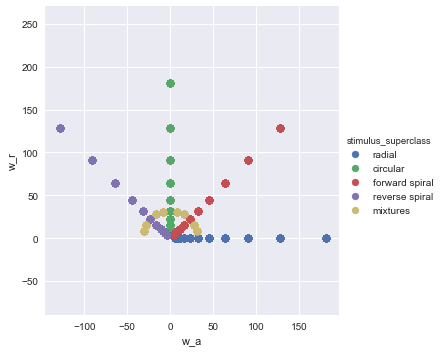

In [4]:
g = sns.FacetGrid(df[df.voxel==0], hue='stimulus_superclass', size=5, aspect=1)
g.map(sns.plt.scatter, 'w_a', 'w_r')
g.add_legend()
_=g.ax.axis('equal')

We also want to be able to see the amplitude response as a function of local spatial frequency. For now, I only do this for `w_r` alone (so, circular stimuli), because there are some details to work out: how to make the `w_a` spatial frequency map respect the `alpha` value and how to combine the two maps in order to get appropriate values for the spirals and mixtures

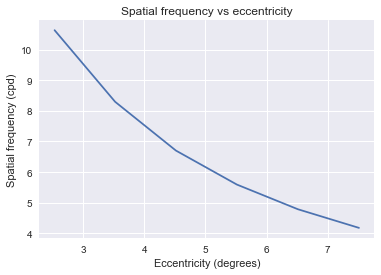

In [6]:
def calculate_stim_cpd(w_r, w_a=0, max_degree_rad=12, alpha=50, stim_size=1080, plot_flag=False):
    _, w_r = sfp.stimuli.create_sf_maps_cpd(stim_size, alpha, max_degree_rad*2, w_r, w_a)
    R = ppt.mkR(stim_size)

    # if max_degree_rad corresponds to the max vertical/horizontal extent, the actual max will be
    # np.sqrt(2*max_degree_rad**2) (this corresponds to the far corner)
    # this should be the radius of the screen, because R starts from the center and goes to the edge 
    R = R/(R.max()/np.sqrt(2*max_degree_rad**2))

    # jbh.showIm([w_r, R], ncols=2)

    # restrict to the eccentricity range we're looking at
    bin_masks = []
    eccen_idx = []
    for i in range(2, 8):
        bin_masks.append((R>i)&(R<(i+1)))
        eccen_idx.append('%s-%s' % (i, i+1))

    eccen_local_freqs = []
    eccens = []
    for m in bin_masks:
        eccens.append(R[m].mean())
        eccen_local_freqs.append(w_r[m].mean())

    if plot_flag:
        sns.plt.plot(eccens, eccen_local_freqs)
        ax = sns.plt.gca()
        ax.set_title('Spatial frequency vs eccentricity')
        ax.set_xlabel('Eccentricity (degrees)')
        _=ax.set_ylabel('Spatial frequency (cpd)')

    return pd.Series(eccen_local_freqs, eccen_idx)

_ = calculate_stim_cpd(181, plot_flag=True)

In [7]:
# these are the stimuli we want to calculate the above curves for
w_r = df[df.stimulus_superclass=='circular'].w_r.unique()
sfs = []

for r in w_r:
    t = calculate_stim_cpd(r)
    t = pd.DataFrame(t, columns=['Local spatial frequency (cpd)'])
    t.index.name = 'eccen'
    t['w_r'] = r
    sfs.append(t)

sfs = pd.concat(sfs)

sfs['stimulus_superclass'] = 'circular'
sfs['w_a'] = 0
sfs = sfs.reset_index()

sfs = sfs.set_index(['stimulus_superclass', 'w_a', 'w_r', 'eccen'])
df = df.set_index(['stimulus_superclass', 'w_a', 'w_r', 'eccen'])
df = df.join(sfs)
df = df.reset_index()

In [15]:
Rmin, Rmax = sfp.first_level_analysis.find_ecc_range_in_degrees(stim[0,:,:], 14)
print("Inside radius of stimulus annulus: %.02f" % Rmin)
print("Outside radius of stimulus annulus: %.02f" % Rmax)

Inside radius of stimulus annulus: 1.24
Outside radius of stimulus annulus: 9.90


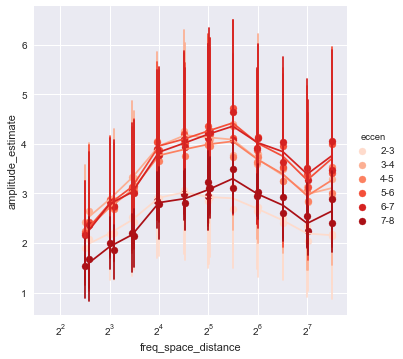

In [5]:
tmp_df = df[df.stimulus_superclass=='circular']
g = sns.FacetGrid(df, hue='eccen', palette='Reds', size=5,)
#g.map(sns.regplot, 'rounded_freq_space_distance', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'rounded_freq_space_distance', 'amplitude_estimate')
g.map_dataframe(sfp.utils.scatter_ci_dist, 'freq_space_distance', 'amplitude_estimate')
for ax in g.axes.flatten():
    ax.set_xscale('log', basex=2)
g.add_legend()

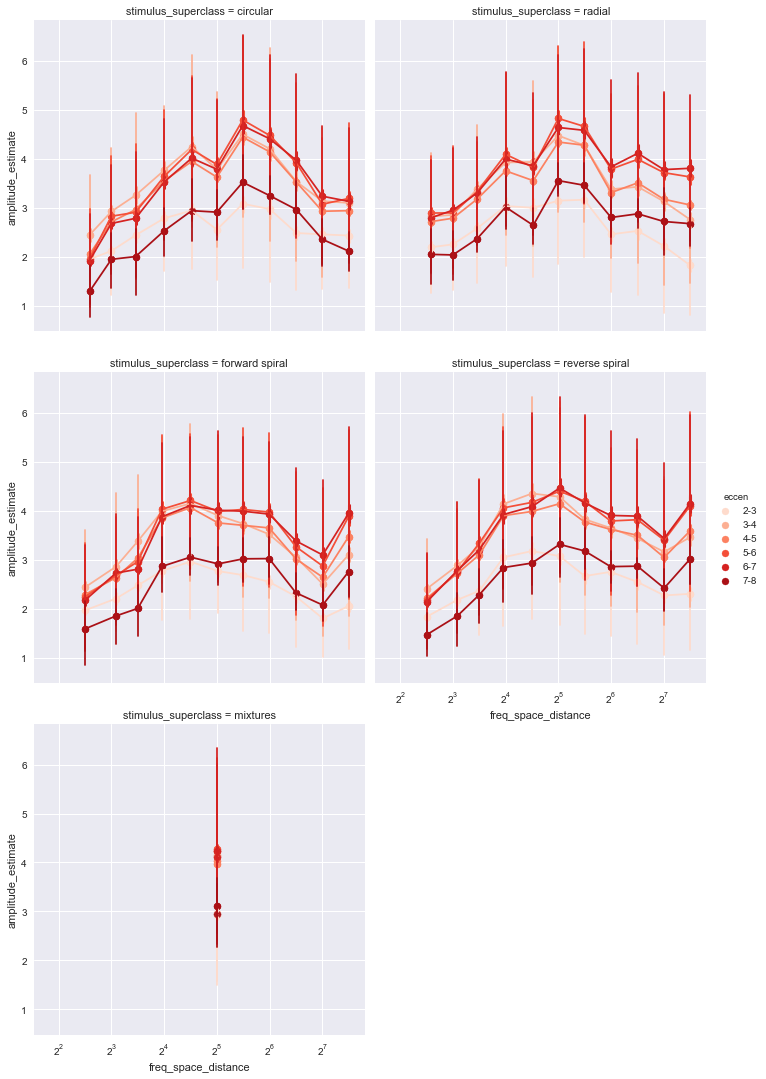

In [69]:
g = sns.FacetGrid(df, hue='eccen', palette='Reds', size=5, col='stimulus_superclass', col_wrap=2,
                  col_order=['circular', 'radial', 'forward spiral', 'reverse spiral', 'mixtures'])
#g.map(sns.regplot, 'freq_space_distance', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'freq_space_distance', 'amplitude_estimate')
g.map_dataframe(sfp.utils.scatter_ci_dist, 'freq_space_distance', 'amplitude_estimate')
for ax in g.axes:
    ax.set_xscale('log', basex=2)
g.add_legend()

If there were no scaling in the visual system, such that neurons at different places in the visual field were expected to have similar properties, the bottom would all line up well, and it doesn't!

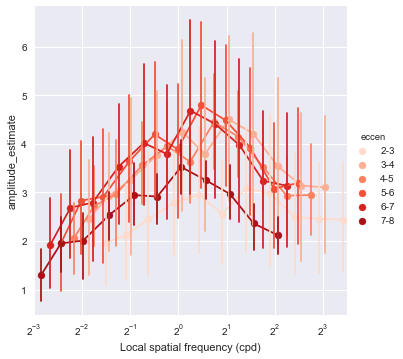

In [14]:
g = sns.FacetGrid(df[df.stimulus_superclass=='circular'], hue='eccen', palette='Reds', size=5,)
#g.map(sns.regplot, 'Local spatial frequency (cpd)', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'Local spatial frequency (cpd)', 'amplitude_estimate')
g.map_dataframe(sfp.utils.scatter_ci_dist, 'Local spatial frequency (cpd)', 'amplitude_estimate')
g.ax.set_xscale('log', basex=2)
g.ax.set_xlim([2**-3, 2**3.5])
g.add_legend()

"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"

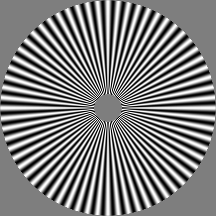
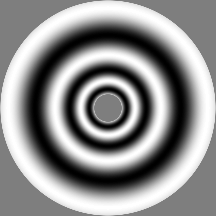
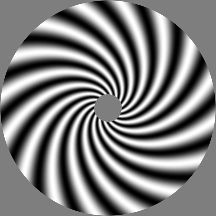
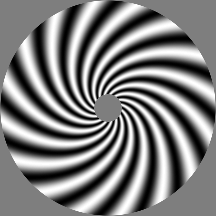

In [17]:
classes_of_interest = []
classes_of_interest.extend(df[(df.stimulus_superclass=='circular')&(df.rounded_freq_space_distance==11)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='radial')&(df.rounded_freq_space_distance==64)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='forward spiral')&(df.rounded_freq_space_distance==23)].stimulus_class.unique())
classes_of_interest.extend(df[(df.stimulus_superclass=='reverse spiral')&(df.rounded_freq_space_distance==23)].stimulus_class.unique())
#classes_of_interest.append(df[df.stimulus_superclass=='mixtures'].stimulus_class.values[0])

stim_idxs = stim_df[stim_df.class_idx.isin(classes_of_interest)].index.values[::8]

jbh.showIm([stim[i, :, :] for i in stim_idxs], ncols=4, zoom=.2)

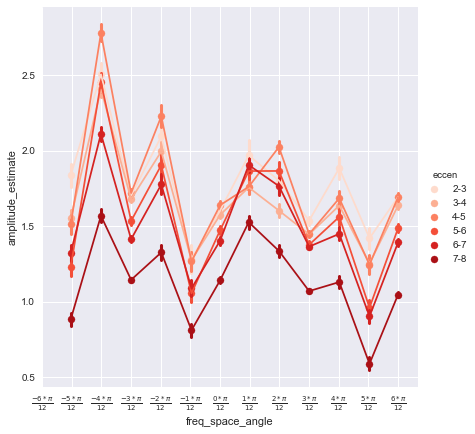

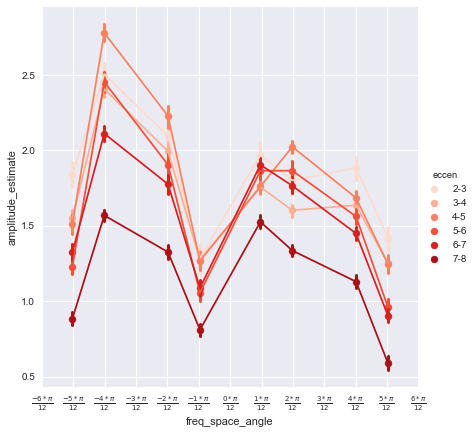

In [52]:
# I know this goes from about -pi/2 to pi/2, in pi/12 steps
ticks = [(np.pi*(i-6)/12.) for i in range(13)]
labels = ['$\\frac{%s*\\pi}{12}$'%(i-6) for i in range(13)]

g = sns.FacetGrid(df, hue='eccen', palette='Reds', size=6)
g.map(sns.regplot, 'freq_space_angle', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'freq_space_angle', 'amplitude_estimate')
#g.map_dataframe(sfp.utils.scatter_ci, 'freq_space_angle', 'amplitude_estimate_median', 'amplitude_estimate_std_error') 
_=g.ax.set_xticks(ticks)
_=g.ax.set_xticklabels(labels)
g.add_legend()

# I know this goes from about -pi/2 to pi/2, in pi/12 steps
ticks = [(np.pi*(i-6)/12.) for i in range(13)]
labels = ['$\\frac{%s*\\pi}{12}$'%(i-6) for i in range(13)]

tmp_df = df[df.stimulus_superclass=='mixtures']
g = sns.FacetGrid(tmp_df, hue='eccen', palette='Reds', size=6)
g.map(sns.regplot, 'freq_space_angle', 'amplitude_estimate', x_estimator=np.mean, fit_reg=False)
g.map_dataframe(sfp.utils.plot_mean, 'freq_space_angle', 'amplitude_estimate')
#g.map_dataframe(sfp.utils.scatter_ci, 'freq_space_angle', 'amplitude_estimate_median', 'amplitude_estimate_std_error') 
_=g.ax.set_xticks(ticks)
_=g.ax.set_xticklabels(labels)
g.add_legend()

"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"
"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"
"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"

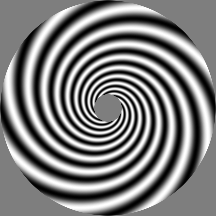
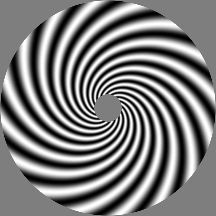
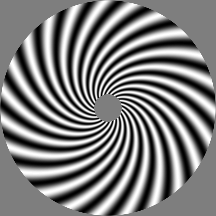
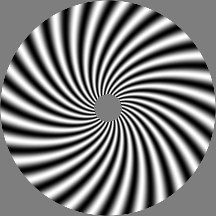
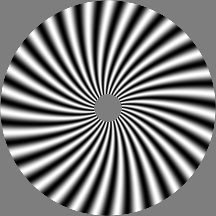
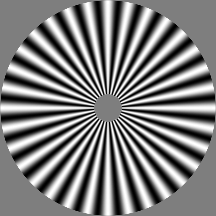
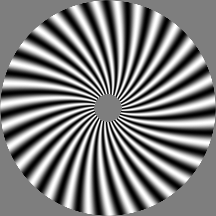
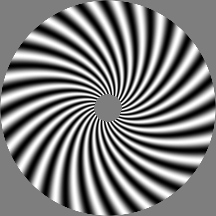
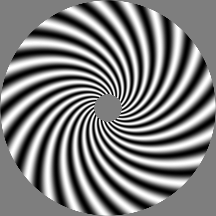
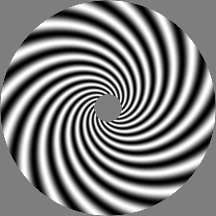
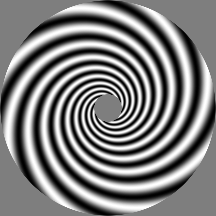
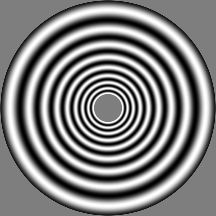

In [85]:
angles = sorted(df.freq_space_angle.unique())
stim_idxs = []
for ang in angles:
    class_of_interest = df[(df.freq_space_angle==ang)&(df.rounded_freq_space_distance==32)].stimulus_class.unique()[0]
    stim_idxs.append(stim_df[stim_df.class_idx==class_of_interest].index[0])

#stim_idxs = stim_df[stim_df.class_idx.isin(classes_of_interest)].index.values[::8]

jbh.showIm([stim[i, :, :] for i in stim_idxs], ncols=4, zoom=.2)

/home/billbrod/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


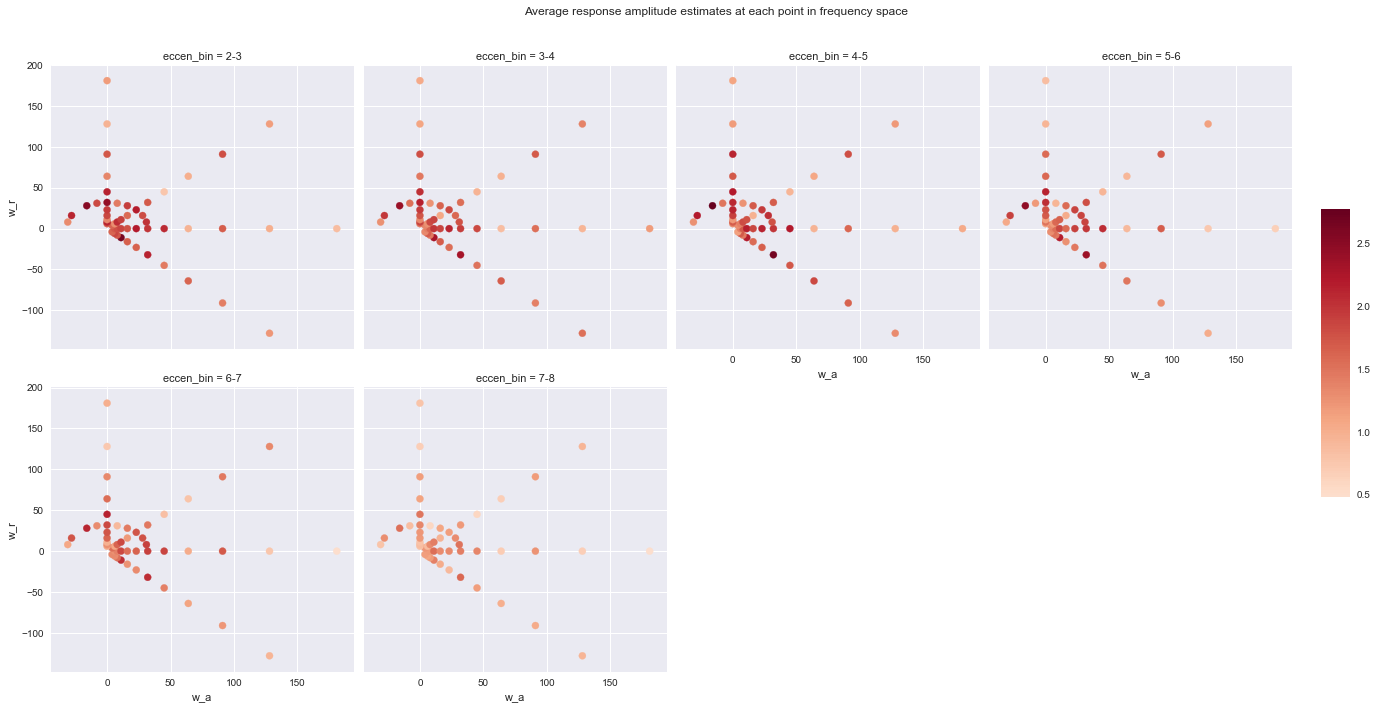

In [16]:
tmp_df = pd.DataFrame(df.groupby(['eccen_bin', 'w_r', 'w_a']).modelmd.mean()).reset_index()

g = sns.FacetGrid(tmp_df, col='eccen_bin', col_wrap=4, size=5)
cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes
g.map(sfp.utils.scatter_heat, 'w_a', 'w_r', 'amplitude_estimate_median', vmin=tmp_df['amplitude_estimate_median'].min(), 
      vmax=tmp_df['amplitude_estimate_median'].max())
sns.plt.colorbar(cax=cbar_ax)
g.fig.subplots_adjust(right=.9, top=.9)
g.fig.suptitle('Average response amplitude estimates at each point in frequency space')

In [17]:
tmp_df = pd.pivot_table(df, 'amplitude_estimate_median', 'rounded_freq_space_distance', 'eccen_bin')
norm_df = tmp_df.copy()
for col in norm_df.columns:
    norm_df[col] = norm_df[col] / norm_df[col].max()

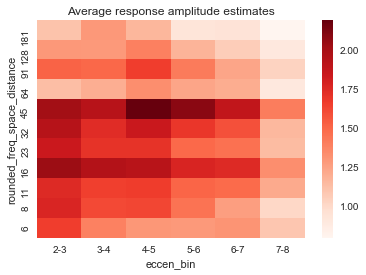

In [80]:
fig = sns.heatmap(tmp_df, cmap='Reds')
fig.invert_yaxis()
fig.set_title('Average response amplitude estimates')

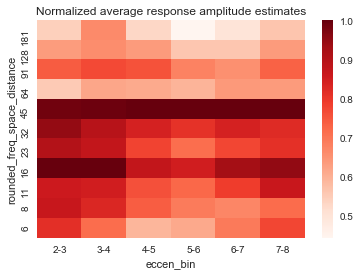

In [81]:
fig = sns.heatmap(norm_df, cmap='Reds')
fig.invert_yaxis()
fig.set_title('Normalized average response amplitude estimates')

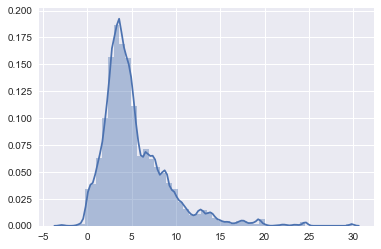

In [20]:
sns.distplot(df.R2.values)

# Double-check design matrix

In order to use this, run everything except for the `sfp.experiment.run` statement first, which will create pictures, one from each class, in the order the `design_df` thinks they are presented. Then run the `sfp.experiment.run` block on a two-monitor setup so one monitor can display the experiment while you have this notebook open in the other. This will allow you to make sure the stimuli are being ordered correctly.

You can also compare `design_df.index.values` to a picture of the design matrix to make sure things got transferred correctly there as well.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import h5py
import os
import pyPyrTools.JBhelpers as jbh

In [3]:
# This file contains the button presses (which also show the TR onsets) 
# and the order the stimuli were presented in (along with their timing)
behav_results = h5py.File('../data/raw_behavioral/2017-Aug-23_Noah_sess1.hdf5')

# This contains the information on each stimulus, allowing us to determine whether
# some stimuli are part of the same class or a separate one.
stim_df = pd.read_csv("../data/stimuli/unshuffled_stim_description.csv", index_col=0)

# Array full of the actual stimuli
stim = np.load('../data/stimuli/unshuffled.npy')

# for this, we just want any run, since they all contain the same classes and we don't care about their order
design_df, stim_length, TR = sfp.first_level_analysis.create_design_df(behav_results, stim_df, 1, drop_blanks=False)
design_df = design_df.reset_index(drop=True).set_index("class_idx")

stim_df['class_idx'] = np.floor(stim_df['index']/8)
stim_df = stim_df.set_index('class_idx')
stim_df['Onset time (TR)'] = design_df['Onset time (TR)']
stim_df = stim_df.reset_index().sort('Onset time (TR)')

stim_df = stim_df.drop_duplicates('class_idx')
stim_idx = stim_df.index.values

../sfp/first_level_analysis.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  design_df['Onset time (TR)'] = np.where(time_from_TR == 0)[1]
/home/billbrod/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [41]:
data = sfp.experiment.run('../data/stimuli/unshuffled.npy', '../data/stimuli/Noah_run01_idx.npy', None, screen=0)

499.7961 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [1920, 1200]. Using actual size
502.1392 	WARNING 	Couldn't measure a consistent frame rate.
  - Is your graphics card set to sync to vertical blank?
  - Are you running other processes on your computer?

502.1521 	ERROR 	Unknown colorSpace: None
502.2874 	WARNING 	t of last frame was 148.41ms (=1/6)
509.5404 	WARNING 	t of last frame was 7253.03ms (=1/0)
509.8382 	WARNING 	t of last frame was 297.80ms (=1/3)
510.0393 	WARNING 	t of last frame was 201.10ms (=1/4)
510.3369 	WARNING 	Multiple dropped frames have occurred - I'll stop bothering you about them!


"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [127.0, 127.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"
"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"

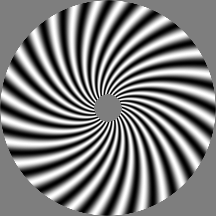
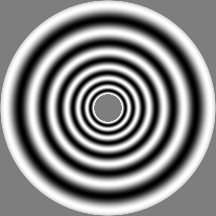
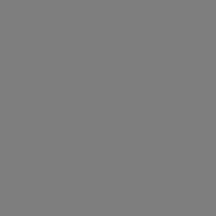
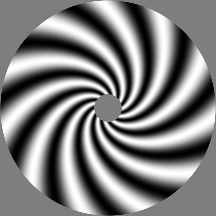
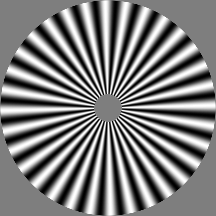
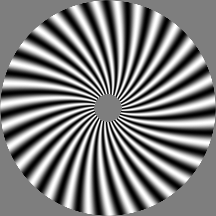
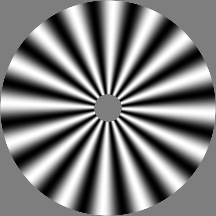
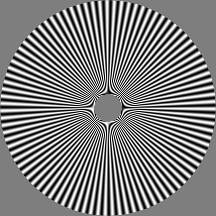
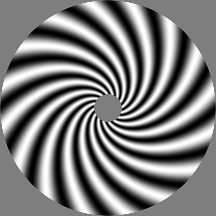
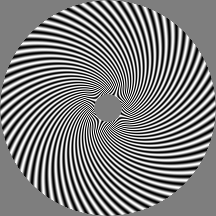

In [33]:
jbh.showIm([stim[i,:,:] for i in stim_idx[:10]], ncols=5, zoom=.2)

"Range: [127.0, 127.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"
"Range: [127.0, 127.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [127.0, 127.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"

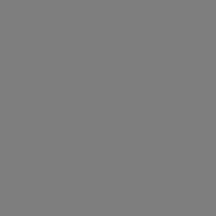
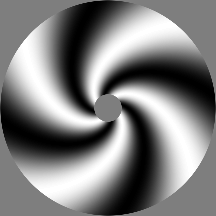
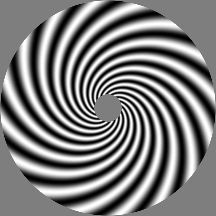
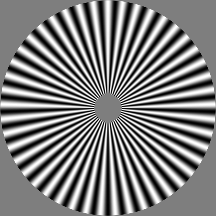
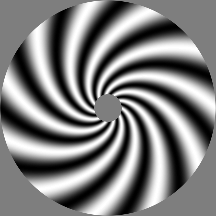
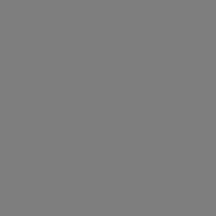
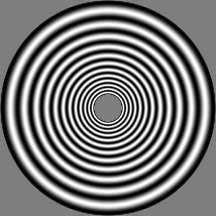
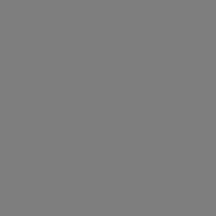
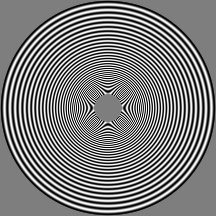
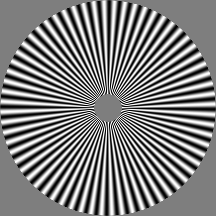

In [34]:
jbh.showIm([stim[i,:,:] for i in stim_idx[10:20]], ncols=5, zoom=.2)

"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"
"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"

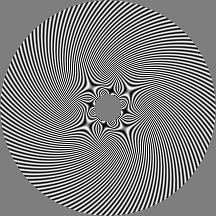
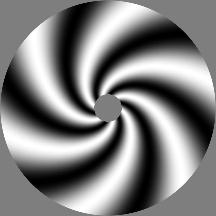
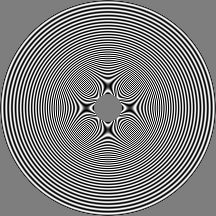
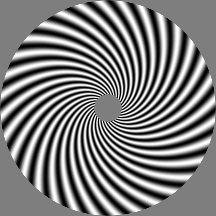
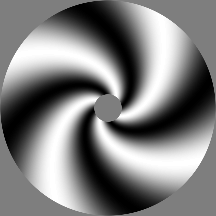
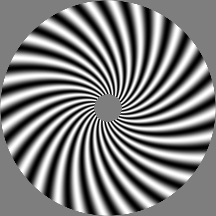
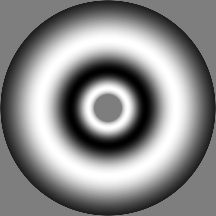
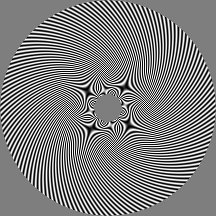
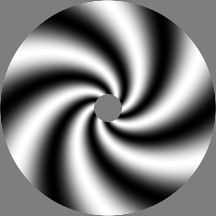
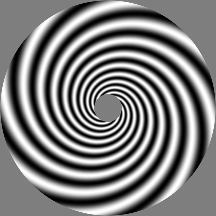

In [35]:
jbh.showIm([stim[i,:,:] for i in stim_idx[20:30]], ncols=5, zoom=.2)

"Range: [127.0, 127.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [127.0, 127.0]Dims: [1080, 1080]*0.20"
"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [127.0, 127.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"

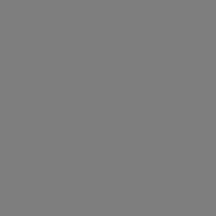
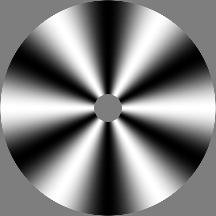
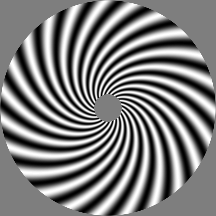
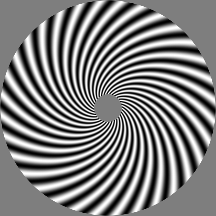
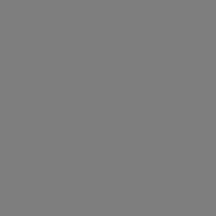
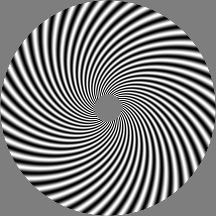
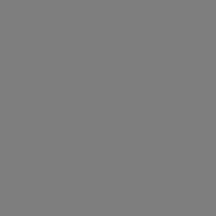
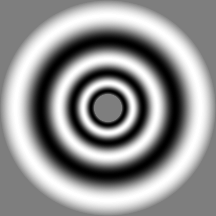
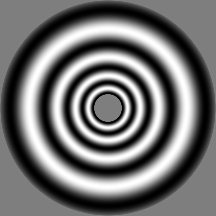
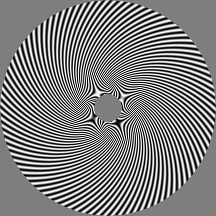

In [36]:
jbh.showIm([stim[i,:,:] for i in stim_idx[30:40]], ncols=5, zoom=.2)

"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [127.0, 127.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"
"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"

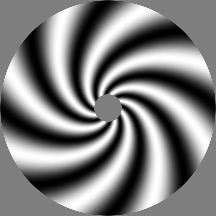
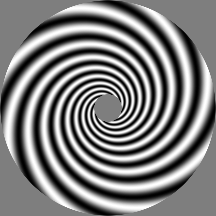
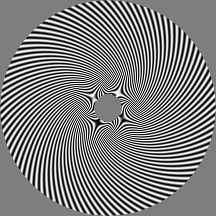
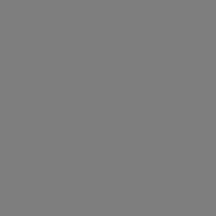
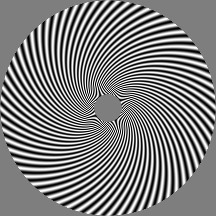
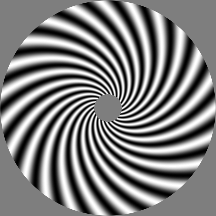
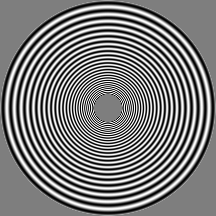
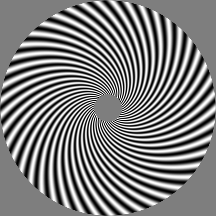
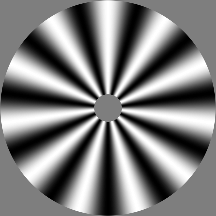
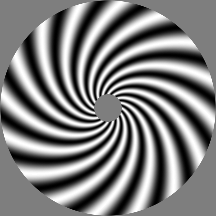

In [37]:
jbh.showIm([stim[i,:,:] for i in stim_idx[40:50]], ncols=5, zoom=.2)

"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [127.0, 127.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"
"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [127.0, 127.0]Dims: [1080, 1080]*0.20"

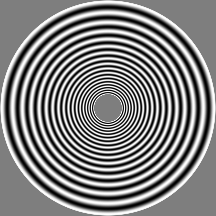
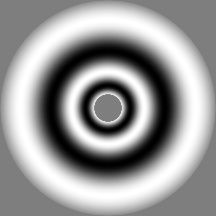
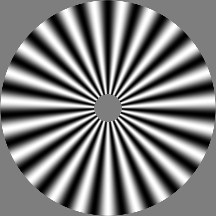
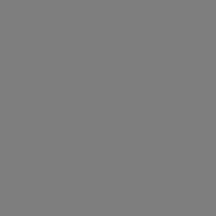
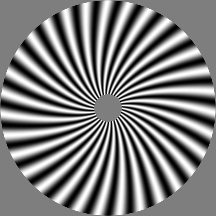
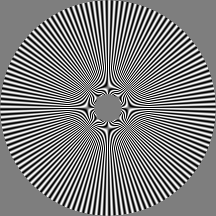
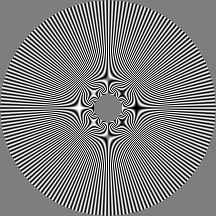
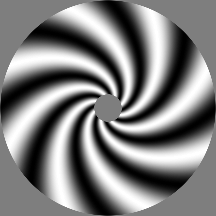
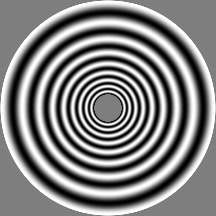
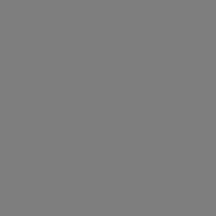

In [39]:
jbh.showIm([stim[i,:,:] for i in stim_idx[50:60]], ncols=5, zoom=.2)

"Range: [0.0, 255.0]Dims: [1080, 1080]*0.20","Range: [0.0, 255.0]Dims: [1080, 1080]*0.20"

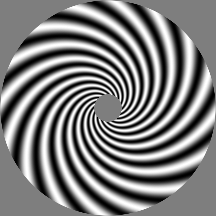
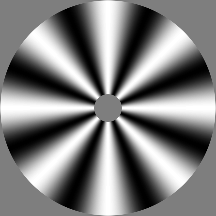

In [40]:
jbh.showIm([stim[i,:,:] for i in stim_idx[60:]], ncols=5, zoom=.2)